# Binary Classification

### Package & File Setup

In [1]:
# Python ≥3.5 is required, this cell ensures all required packages are imported and a GPU is detected (if available).
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'): # GPU detection
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os, sys
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import json
import PIL.Image
import pathlib
import pickle
import random
from tensorflow import keras as K

# To make this notebook's output stable across runs 
np.random.seed(788203)
tf.random.set_seed(788203)
random.seed(788203)

In [4]:
# Main paths removed for privacy
X_train_path = r"\leftImg8bit\train/*/*.png"
X_train_extra_path = r"\leftImg8bit\train_extra/*/*.png" # Extra = coarse annotated images
Y_train_path = r"\gtFine\train/*/*.json"
Y_train_extra_path = r"\gtFine\train_extra/*/*.json"
X_train_files = glob.glob(X_train_path)
X_train_extra_files = glob.glob(X_train_extra_path)
Y_train_files = glob.glob(Y_train_path)
Y_train_extra_files = glob.glob(Y_train_extra_path)

In [5]:
# Main paths removed for privacy
X_val_path = r"\leftImg8bit\val/*/*.png"
Y_val_path = r"\gtFine\val/*/*.json"
X_val_files = glob.glob(X_val_path)
Y_val_files = glob.glob(Y_val_path)

In [44]:
# Main paths removed for privacy
X_test_path = r"\leftImg8bit\test/*/*.png"
Y_test_path = r"\gtFine\test/*/*.json"
X_test_files = glob.glob(X_test_path)
Y_test_files = glob.glob(Y_test_path)

### Data Pre-Processing

In [7]:
def sstobinarywithinfo(files): # Convert cluster labels to required binary label (1 for car, 0 for no car)
    y = [None] * len(files)
    total = 0
    for i in range(0, len(files)):
        with open(files[i]) as f:
            data = json.load(f)
        for j in range(0, len(data['objects'])):
            if data['objects'][j]["label"] == "car" or data['objects'][j]["label"] == "cargroup" or data['objects'][j]["label"] == "bus" or data['objects'][j]["label"] == "caravan" or data['objects'][j]["label"] == "trailer" or data['objects'][j]["label"] == "busgroup" or data['objects'][j]["label"] == "truck" or data['objects'][j]["label"] == "truckgroup":
                y[i] = 1
                total += 1
                break
            y[i] = 0
    print("-------------------------")
    print(str(len(files)) + " total images.")
    print(str(total) + " images with cars.")
    print(str(len(files) - total) + " images without cars.")
    return y

In [8]:
y_train_class = sstobinarywithinfo(Y_train_files)
y_train_extra_class = sstobinarywithinfo(Y_train_extra_files)
y_val_class = sstobinarywithinfo(Y_val_files)
y_test_class = sstobinarywithinfo(Y_test_files) # Incorrect Labels

-------------------------
2975 total images.
2847 images with cars.
128 images without cars.
-------------------------
19998 total images.
17390 images with cars.
2608 images without cars.
-------------------------
500 total images.
482 images with cars.
18 images without cars.
-------------------------
1525 total images.
0 images with cars.
1525 images without cars.


### Data Creation

In [2]:
IMG_SIZE = 132 # Scale down images to (IMG_SIZE x IMG_SIZE)

In [11]:
def create_data(X_files, y_class): # Apply flipping transformation for all images.
    output_data = []
    for i in range(0, len(X_files)):
        img_array = cv2.imread(X_files[i])
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        new_array_flipped = cv2.flip(new_array, 1)  # Reflect images for more data
        if y_class[i] == 1:
            output_data.append([new_array, 1])
            output_data.append([new_array_flipped, 1]) # Add reflected data
        if y_class[i] == 0:
            output_data.append([new_array, 0])
            output_data.append([new_array_flipped, 0]) # Add reflected data
        if i % 400 == 0: # Simple progress monitor (this process takes a long time)
            print(str(i) + "/" + str(len(X_files)))
    return output_data

In [13]:
training_data = create_data(X_train_files, y_train_class)
print("Training data created")
training_extra_data = create_data(X_train_extra_files, y_train_extra_class)
print("Training data (extra) created")
val_data = create_data(X_val_files, y_val_class)
print("Validation data created")

0/2975
400/2975
800/2975
1200/2975
1600/2975
2000/2975
2400/2975
2800/2975
Training data created
0/19998
400/19998
800/19998
1200/19998
1600/19998
2000/19998
2400/19998
2800/19998
3200/19998
3600/19998
4000/19998
4400/19998
4800/19998
5200/19998
5600/19998
6000/19998
6400/19998
6800/19998
7200/19998
7600/19998
8000/19998
8400/19998
8800/19998
9200/19998
9600/19998
10000/19998
10400/19998
10800/19998
11200/19998
11600/19998
12000/19998
12400/19998
12800/19998
13200/19998
13600/19998
14000/19998
14400/19998
14800/19998
15200/19998
15600/19998
16000/19998
16400/19998
16800/19998
17200/19998
17600/19998
18000/19998
18400/19998
18800/19998
19200/19998
19600/19998
Training data (extra) created
0/500
400/500
Validation data created


### Save Data

In [14]:
pickle_out = open("training_data.pickle", "wb")
pickle.dump(training_data, pickle_out)
pickle_out.close()

pickle_out = open("training_extra_data.pickle", "wb")
pickle.dump(training_extra_data, pickle_out)
pickle_out.close()

pickle_out = open("val_data.pickle", "wb")
pickle.dump(val_data, pickle_out)
pickle_out.close()

### Load Data

In [15]:
training_data = pickle.load(open("training_data.pickle", "rb"))
training_extra_data = pickle.load(open("training_extra_data.pickle", "rb"))
val_data = pickle.load(open("val_data.pickle", "rb"))

In [16]:
def datacheck(data): # For checking whether operations on the data have been completed correctly
    for i in range(0, len(data)):
        print(data[i][1])

In [17]:
combined_data_new = training_data + training_extra_data + val_data # Stitch together datasets for a larger more diverse dataset
combined_data_sorted = sorted(combined_data_new, key=lambda x: str(x[1])) # Sort by class to remove data that is not needed for this classification problem

In [18]:
combined_data_eq = []
for i in range(0, 2*5508): # 5508 officially, doubled for flipped images
    combined_data_eq.append(combined_data_sorted[i])

In [19]:
datacheck(combined_data_eq)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [26]:
combined_data = combined_data_eq
random.shuffle(combined_data)

In [27]:
datacheck(combined_data)

1
0
0
0
0
1
1
0
0
1
0
0
0
1
0
0
1
1
0
0
0
1
1
1
0
0
0
0
1
0
0
1
0
0
0
1
0
0
1
0
0
1
1
1
1
0
1
1
1
0
0
0
0
0
0
1
1
1
1
1
0
0
0
1
0
1
0
1
0
1
0
1
0
1
1
0
1
1
1
0
1
1
0
1
1
0
1
1
0
0
0
0
0
1
0
1
0
0
1
1
0
1
0
1
0
0
1
0
1
0
0
0
1
0
1
1
0
1
1
0
0
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
0
0
0
1
0
0
0
1
1
0
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
1
0
1
1
1
0
0
0
0
1
1
0
1
1
1
0
0
0
0
1
1
0
0
0
1
0
0
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
0
0
0
0
1
0
0
1
0
1
0
0
1
1
1
0
1
0
0
1
0
1
0
1
1
0
1
0
0
1
1
0
1
0
1
0
1
1
0
1
1
1
0
1
1
0
0
0
0
1
1
0
1
1
1
0
0
1
1
1
0
1
1
0
1
1
0
1
0
1
1
0
1
0
1
0
1
1
0
1
0
0
0
0
1
0
0
0
1
1
0
0
1
0
0
1
0
0
0
1
0
1
0
0
0
0
0
1
0
1
0
0
0
0
0
1
0
1
1
1
1
1
0
0
0
0
1
0
0
0
0
0
1
1
1
0
0
1
1
1
1
0
1
1
1
1
0
1
0
0
1
0
1
0
0
0
0
0
0
1
1
0
0
1
0
0
0
1
1
0
1
0
1
1
1
1
0
1
0
0
0
1
1
1
0
0
1
1
0
1
0
1
1
0
1
0
1
0
1
0
0
0
0
1
0
0
1
0
1
1
0
1
0
1
1
1
0
1
1
1
0
1
1
1
1
1
0
1
0
0
1
1
0
1
0
0
0
0
0
0
0
1
1
1
0
1
1
1
1
1
0
0
0
1
0
0
1
0
0
1
1
1
1
0
0
1
0
0
1
0
1
0
1
0
1
1
1
0
1
1
1
1
0
1
1
0
1
0
1
1
0
0
0
1
1
0


0
1
1
1
1
1
1
0
1
1
0
1
1
1
1
0
1
1
1
0
0
1
0
0
0
0
1
0
0
0
0
0
1
0
1
1
1
0
0
0
0
1
0
0
0
0
0
0
1
1
0
0
1
1
0
1
0
1
0
1
0
0
0
0
1
0
1
1
1
1
0
1
1
1
1
0
0
1
1
0
1
0
0
1
1
0
0
0
0
0
0
1
0
1
1
0
0
1
1
0
1
0
0
0
1
1
0
1
1
1
1
1
1
0
0
1
1
1
0
0
0
1
1
0
1
0
0
1
1
0
1
0
0
1
0
1
0
0
1
0
1
0
0
0
1
1
0
1
1
1
0
1
0
0
0
0
1
1
0
0
1
1
0
0
1
1
0
1
1
0
0
1
1
1
1
0
1
0
1
0
1
1
1
1
1
1
1
0
1
0
0
1
1
1
1
0
0
1
1
0
1
0
0
1
1
0
0
0
0
0
1
1
0
0
1
1
0
1
0
1
1
1
1
0
0
0
1
0
1
0
1
1
0
0
0
0
1
0
1
0
1
1
0
1
0
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
0
1
0
1
0
1
1
0
0
0
0
1
0
0
0
1
1
0
1
0
1
1
0
0
0
1
1
0
1
0
0
0
0
1
0
0
0
0
0
0
0
1
1
0
1
1
1
1
1
0
1
1
0
0
0
0
1
1
0
0
1
0
0
0
1
0
0
1
0
0
0
1
0
0
0
1
0
0
0
0
0
1
0
1
1
1
0
0
0
1
0
0
0
1
1
1
0
0
0
0
1
1
1
1
0
1
1
1
1
0
0
1
0
1
0
0
1
0
1
1
0
1
0
1
0
0
0
0
0
1
0
1
1
1
0
1
0
0
1
1
1
1
1
1
0
1
1
0
0
0
0
0
1
1
0
0
1
1
1
0
1
1
0
0
0
0
0
0
0
1
0
1
1
1
0
0
0
0
1
1
0
0
0
1
0
1
1
1
0
0
1
1
0
1
1
1
0
0
0
0
0
1
1
0
0
1
0
0
1
0
0
1
0
0
0
1
1
0
0
0
1
0
1
0
0
0
1
0
0
1
1
0
1
0
1


In [29]:
pickle_out = open("combined_data_random.pickle", "wb") # Save randomised data
pickle.dump(combined_data, pickle_out)
pickle_out.close()

In [3]:
combined_data = pickle.load(open("combined_data_random.pickle", "rb")) # Load randomised data

In [4]:
def makexy(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    y = np.asarray(y).astype('float32').reshape((-1,1))
    return X, y

In [5]:
training_data = combined_data[:-1000]
test_data = combined_data[-1000:]
X_train, y_train = makexy(training_data)
X_test, y_test = makexy(test_data)

### Create Initial Model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

X_train_norm = X_train/255.0

model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Dense(1))
model.add(Activation('sigmoid')) # Add dropout to help with overfitting

model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [10]:
model.fit(X_train_norm, y_train, batch_size=8, epochs=10, validation_split=0.2) # no specified val data as it was combined with training data earlier.

Epoch 1/10
1002/1002 [==============================] - 13s 13ms/step - loss: 0.5934 - accuracy: 0.6830 - val_loss: 0.4724 - val_accuracy: 0.7754
Epoch 2/10
1002/1002 [==============================] - 12s 12ms/step - loss: 0.4702 - accuracy: 0.7852 - val_loss: 0.4604 - val_accuracy: 0.7859
Epoch 3/10
1002/1002 [==============================] - 12s 12ms/step - loss: 0.4113 - accuracy: 0.8174 - val_loss: 0.4295 - val_accuracy: 0.7999
Epoch 4/10
1002/1002 [==============================] - 12s 12ms/step - loss: 0.3621 - accuracy: 0.8444 - val_loss: 0.3807 - val_accuracy: 0.8433
Epoch 5/10
1002/1002 [==============================] - 12s 12ms/step - loss: 0.3142 - accuracy: 0.8709 - val_loss: 0.3060 - val_accuracy: 0.8713
Epoch 6/10
1002/1002 [==============================] - 12s 12ms/step - loss: 0.2639 - accuracy: 0.8934 - val_loss: 0.2904 - val_accuracy: 0.8862
Epoch 7/10
1002/1002 [==============================] - 12s 12ms/step - loss: 0.2118 - accuracy: 0.9209 - val_loss: 0.3008 -

### Tweak Model

In [1]:
# This code initialises all required packages, variables and seeds for when resetting kernel and tweaking model.
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'): # GPU detection
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os, sys
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import json
import PIL.Image
import pathlib
import pickle
import random
from tensorflow import keras as K

# To make this notebook's output stable across runs 
np.random.seed(788203)
tf.random.set_seed(788203)
random.seed(788203)

X_test_path = r"D:\Datasets\leftImg8bit\test/*/*.png"
Y_test_path = r"C:\Users\shroo\OneDrive - Nottingham Trent University\Year 4\Research Project\Python Testing\gtFine\test/*/*.json"
X_test_files = glob.glob(X_test_path)
Y_test_files = glob.glob(Y_test_path)

IMG_SIZE = 132

combined_data = pickle.load(open("combined_data_random.pickle", "rb")) # Load randomised data

def makexy(data):
    X = []
    y = []

    for features, label in data:
        X.append(features)
        y.append(label)

    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    y = np.asarray(y).astype('float32').reshape((-1,1))
    
    return X, y

training_data = combined_data[:-1000]
test_data = combined_data[-1000:]
X_train, y_train = makexy(training_data)
X_test, y_test = makexy(test_data)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input

X_train_norm = X_train/255.0

model = Sequential()

model.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="model_input"))

model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (5, 5)))

model.add(Conv2D(128, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(256, (3, 3),  name = "visualised_layer"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(1024))
model.add(Activation('relu')) # Added to reduce overfitting

model.add(Dense(64))
model.add(Activation('relu')) # Added to reduce overfitting

model.add(Dropout(0.5)) # Added to reduce overfitting with recommended p value
model.add(Dense(1, activation = 'sigmoid'))

In [3]:
model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

In [4]:
model.fit(X_train_norm, y_train, batch_size = 16, epochs = 20, validation_split = 0.2) # no specified val data as it was combined with training data earlier.

Epoch 1/20
501/501 [==============================] - 6s 8ms/step - loss: 0.6698 - accuracy: 0.6073 - val_loss: 0.6765 - val_accuracy: 0.5160
Epoch 2/20
501/501 [==============================] - 3s 6ms/step - loss: 0.5905 - accuracy: 0.7036 - val_loss: 0.4836 - val_accuracy: 0.8014
Epoch 3/20
501/501 [==============================] - 3s 6ms/step - loss: 0.5247 - accuracy: 0.7514 - val_loss: 0.5113 - val_accuracy: 0.7505
Epoch 4/20
501/501 [==============================] - 3s 7ms/step - loss: 0.4779 - accuracy: 0.7796 - val_loss: 0.4106 - val_accuracy: 0.8224
Epoch 5/20
501/501 [==============================] - 3s 6ms/step - loss: 0.4514 - accuracy: 0.7943 - val_loss: 0.4045 - val_accuracy: 0.8273
Epoch 6/20
501/501 [==============================] - 3s 6ms/step - loss: 0.4332 - accuracy: 0.8025 - val_loss: 0.5770 - val_accuracy: 0.7221
Epoch 7/20
501/501 [==============================] - 3s 6ms/step - loss: 0.4212 - accuracy: 0.8100 - val_loss: 0.3669 - val_accuracy: 0.8403
Epoch 

### Evaluation

In [10]:
X_test_norm = X_test/255.0
y_pred = model.predict(X_test_norm)

In [11]:
y_pred_class = (model.predict(X_test/255.0) > 0.5).astype("int32") # Convert from probabilities to "0" and "1" classes

In [7]:
for i in range(0, len(y_pred)):
    print(y_pred_class[i], y_test[i])

[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[1] [1.]
[1] [1.]
[1] [0.]
[0] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[1] [1.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [0.]
[0] [0.]
[1] [1.]
[0] [0.]
[0] [0.]
[0] [1.]
[1] [1.]
[1] [1.]
[0] [0.]
[

In [8]:
# Print indexes of images with incorrect labels for checking purposes. 
count = 0
for i in range(0, len(y_pred_class)): # Worth talking about: image 12
    if y_pred_class[i] != y_test[i]:
        count += 1
        print(i)
print("Total incorrect labels: " + str(count) + " which is " + str(1 - (count/len(y_test))) + "% accurate")

5
7
17
29
33
48
53
61
63
66
86
92
93
107
147
153
160
161
172
202
203
204
205
226
235
245
246
261
273
278
281
287
288
291
296
301
314
316
339
340
343
346
351
364
367
373
393
396
398
409
411
418
425
436
442
445
447
461
467
469
472
493
500
502
511
527
530
540
546
550
551
552
553
557
565
578
581
584
586
593
605
622
644
649
652
657
660
664
666
681
690
693
722
729
740
747
776
780
788
792
798
802
819
827
850
855
865
887
894
895
919
929
933
946
950
951
966
967
970
Total incorrect labels: 119 which is 0.881% accurate


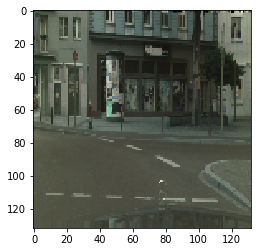

Prediction: 0   vs.   Actual: 0


In [35]:
from matplotlib import pyplot as plt
i = 22 # Index of test set to be checked. Use any number listed from output of above cell.
plt.imshow(X_test[i], interpolation='nearest')
plt.show()
print("Prediction: " + str(int(y_pred_class[i])) + "   vs.   Actual: " + str(int(y_test[i])))

### Save Model

In [9]:
model.save("BinaryClass")

INFO:tensorflow:Assets written to: BinaryClass\assets


### Load Model

In [9]:
model = keras.models.load_model("BinaryClass") # or add the path

In [98]:
X_test_norm = X_test/255.0
y_pred = model.predict(X_test_norm)

In [99]:
y_pred_class = (y_pred > 0.5).astype("int32") # Convert from probabilities to "0" and "1" classes

### Heatmap

In [67]:
testimg_index = 281 # Index of test set for heatmap to be generated
image = cv2.imread(X_test_files[testimg_index])
image = cv2.resize(image, (132, 132))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0) # Apply pre-processing

func_model = model
preds = func_model.predict(image) 
pred_i = (preds > 0.5).astype("int32")
pred_i = pred_i[0][0]
print(pred_i)

1


In [68]:
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2

class GradCAM: # GradCAM algorithm
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        # print(convOutputs.shape)
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

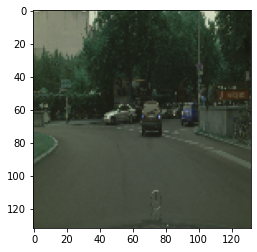

In [69]:
image = cv2.imread(X_test_files[testimg_index])
image = cv2.resize(image, (132, 132))

# checking how it looks 
plt.imshow(image, cmap="gray")
plt.show()

image = tf.expand_dims(image, axis=0)     # from 132 x 132 to 132 x 132 x 1 
image = tf.divide(image, 255)              # normalize
#image = tf.reshape(image, [1, 132, 132, 1])  # reshape to add batch dimension

In [70]:
icam = GradCAM(model, pred_i, 'visualised_layer') 

heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (132, 132))

image = cv2.imread(X_test_files[testimg_index])
image = cv2.resize(image, (132, 132))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(132, 132) (132, 132, 3)


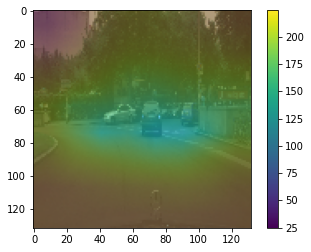

In [71]:
plt.colorbar(plt.imshow(output))
plt.show()

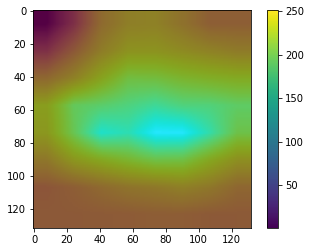

In [72]:
plt.colorbar(plt.imshow(heatmap))
plt.show()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       204928    
                                                                 
 activation_1 (Activation)   (None, 21, 21, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    